# Benchmarks corrections of deformations by calculating localization precision between cycles.

Computer name: atlantis


Processing clusters:   0%|          | 0/1107 [00:00<?, ?it/s]

Processing clusters: 100%|██████████| 1107/1107 [00:00<00:00, 23528.28it/s]


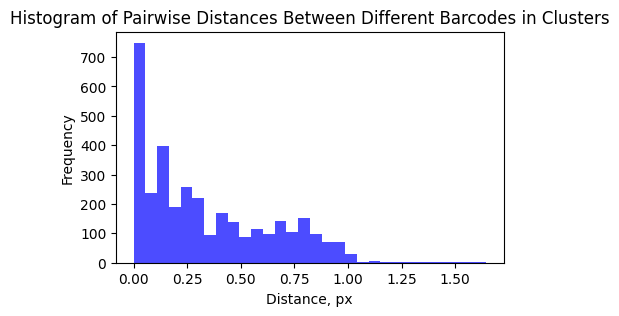

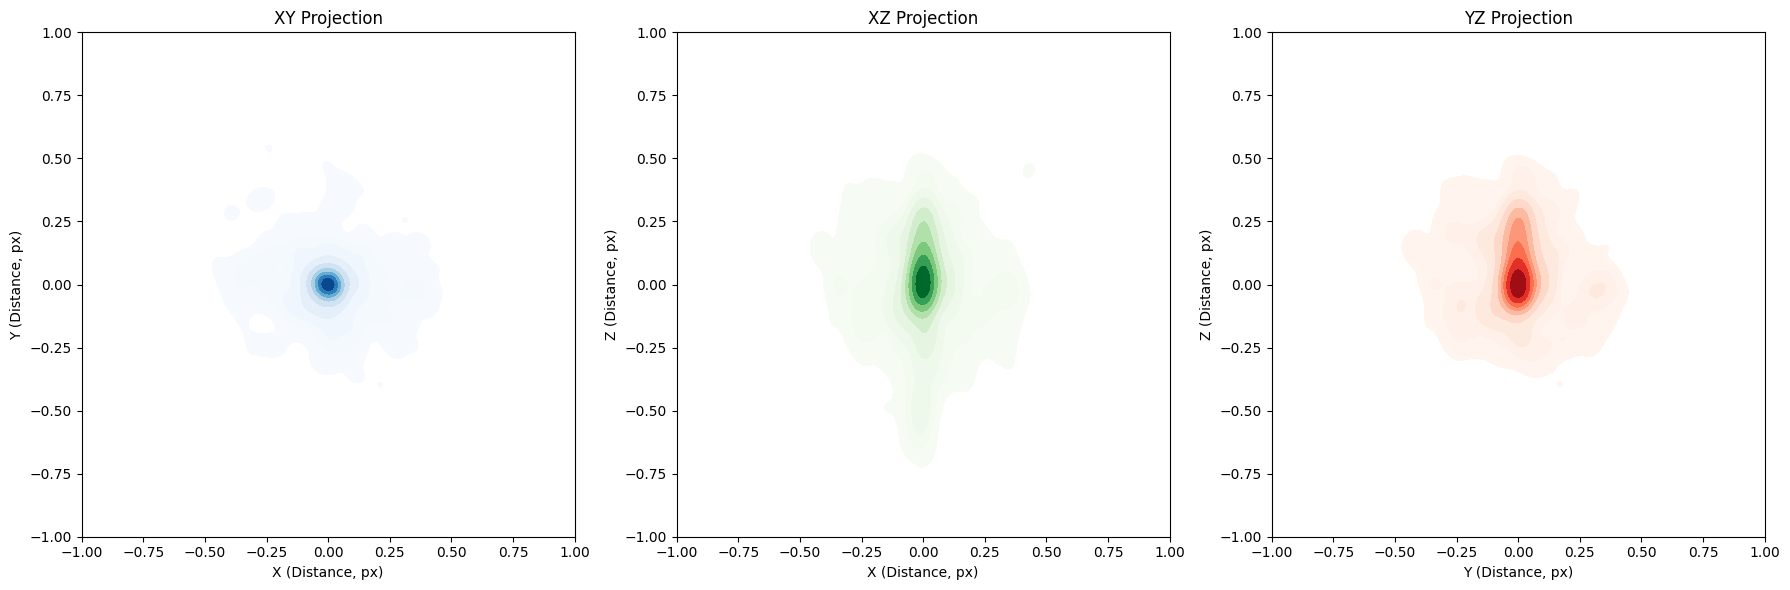

In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from astropy.table import Table
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import socket

# Get the computer name (hostname)
def get_computer_name():
    return socket.gethostname()

# Function to read localizations from a file
def read_localizations(file_path):
    """Read a localizations table from a file."""
    return Table.read(file_path, format='ascii.ecsv')

# Function to compute the center of mass (centroid) for a set of points
def compute_center_of_mass(coordinates):
    """Compute the center of mass of a cluster."""
    return np.mean(coordinates, axis=0)

# Function to translate localizations to the center of mass of each cluster
def translate_to_center_of_mass(coordinates, center_of_mass):
    """Translate the points in a cluster so that the center of mass is at the origin."""
    return coordinates - center_of_mass

# Function to compute pairwise distances within a cluster
def compute_pairwise_distances(coordinates):
    """Compute pairwise distances between points in a cluster."""
    num_points = len(coordinates)
    distances = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distances.append(dist)
    return distances

# Function to plot the 2D kernel density estimate of XY, XZ, and YZ projections
def plot_translated_localizations(translated_coordinates_all_clusters, figure_label = ', microns'):
    """Plot the 2D KDE density for XY, XZ, and YZ projections for all clusters."""
    all_xy = []
    all_xz = []
    all_yz = []

    # Collect all the translated coordinates for each projection (XY, XZ, YZ)
    for cluster_coords in translated_coordinates_all_clusters:
        cluster_coords = np.array(cluster_coords)
        #all_xy.append(cluster_coords[:, :2])  # XY projection
        #all_xz.append(cluster_coords[:, [0, 2]])  # XZ projection
        #all_yz.append(cluster_coords[:, 1:])  # YZ projection
        all_xy.append(cluster_coords[:, [0, 2]])  # XY projection
        all_xz.append(cluster_coords[:, :2])  # XZ projection
        all_yz.append(cluster_coords[1:,:])  # YZ projection
    
    all_xy = np.vstack(all_xy)
    all_xz = np.vstack(all_xz)
    all_yz = np.vstack(all_yz)

    # Create a figure with three subplots for XY, XZ, and YZ projections
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # XY projection
    sns.kdeplot(x=all_xy[:, 0], y=all_xy[:, 1], ax=axes[0], fill=True, cmap="Blues", thresh=0.05)
    axes[0].set_title('XY Projection')
    axes[0].set_xlabel(f'X ({figure_label})')
    axes[0].set_ylabel(f'Y ({figure_label})')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)

    # XZ projection
    sns.kdeplot(x=all_xz[:, 0], y=all_xz[:, 1], ax=axes[1], fill=True, cmap="Greens", thresh=0.05)
    axes[1].set_title('XZ Projection')
    axes[1].set_xlabel(f'X ({figure_label})')
    axes[1].set_ylabel(f'Z ({figure_label})')

    # YZ projection
    sns.kdeplot(x=all_yz[:, 0], y=all_yz[:, 1], ax=axes[2], fill=True, cmap="Reds", thresh=0.05)
    axes[2].set_title('YZ Projection')
    axes[2].set_xlabel(f'Y ({figure_label})')
    axes[2].set_ylabel(f'Z ({figure_label})')

    for ax in axes:
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        
    plt.tight_layout()
    plt.show()

# Main function to process the localizations, run clustering, and plot results
def process_localizations(file_path=None, localizations=None, distance_threshold=1.0):
    """
    Process localizations either from a file or from provided localizations data, 
    run KDTree clustering, and plot the results.
    """

    # If localizations are not provided, read from the file
    if localizations is None:
        if file_path is None:
            raise ValueError("Either file_path or localizations must be provided.")
        localizations = read_localizations(file_path)

    if 'xcentroid' in localizations.keys():
        table_type = 'localizations'
        x_label, y_label, z_label = "xcentroid","ycentroid","zcentroid"
        figure_label = 'Distance, px'
    else:
        table_type = 'trace'
        x_label, y_label, z_label = "x","y","z"
        figure_label = 'Distance, microns'
        
    # Extract coordinates and barcode identities
    coordinates = []
    barcodes = []
    for row in tqdm(localizations, desc="Processing localizations"):
        barcode_number = int(row["Barcode #"])
        x = row[x_label]
        y = row[y_label]
        z = row[z_label]
        coordinates.append([x, y, z])
        barcodes.append(barcode_number)
    
    coordinates = np.array(coordinates)
    barcodes = np.array(barcodes)

    # Build KDTree and find clusters
    tree = KDTree(coordinates)
    clusters = tree.query_ball_tree(tree, distance_threshold)

    # Dictionary to hold pairwise distances for different barcodes within the same cluster
    pairwise_distances = []
    translated_coordinates_all_clusters = []

    # Iterate over the clusters to extract barcodes and calculate distances
    for cluster in tqdm(clusters, desc="Processing clusters"):
        if len(cluster) > 1:  # Only process clusters with more than one point
            cluster_barcodes = barcodes[cluster]
            cluster_coordinates = coordinates[cluster]
            
            # Compute the center of mass of the cluster
            center_of_mass = compute_center_of_mass(cluster_coordinates)
            
            # Translate all points to the center of mass
            translated_coordinates = translate_to_center_of_mass(cluster_coordinates, center_of_mass)
            translated_coordinates_all_clusters.append(translated_coordinates)
            
            # Check if there are different barcodes in the cluster
            if len(np.unique(cluster_barcodes)) > 1:
                distances = compute_pairwise_distances(cluster_coordinates)
                pairwise_distances.extend(distances)

    # Plot histogram of pairwise distances
    plt.figure(figsize=(5, 3))
    plt.hist(pairwise_distances, bins=30, color='blue', alpha=0.7)
    plt.xlabel(figure_label)
    plt.ylabel('Frequency')
    plt.title('Histogram of Pairwise Distances Between Different Barcodes in Clusters')
    plt.show()

    # Visualize the translated localizations with 2D KDE projections
    plot_translated_localizations(translated_coordinates_all_clusters, figure_label = figure_label)


print(f"Computer name: {get_computer_name()}")

if get_computer_name()=="atlantis":
    
    
    # trace table
    folder = '/home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/tracing/data/'
    file_path = folder+"Trace_3D_barcode_KDtree_ROI-1.ecsv"    
    
    # localizations table
    folder = '/home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/localize_3d/data/'
    file_path = folder+"localizations_3D_barcode_registered_global_xy.dat"
    file_path = folder+"localizations_3D_barcode_registered_local_xyz.dat"
    
else:
    file_path = "/home/marcnol/data/blobel/tracing/data/Trace_3D_barcode_mask-mask0_ROI-1.ecsv"

process_localizations(file_path)


Computer name: atlantis


Processing clusters:   0%|          | 0/1107 [00:00<?, ?it/s]

Processing clusters: 100%|██████████| 1107/1107 [00:00<00:00, 33181.79it/s]


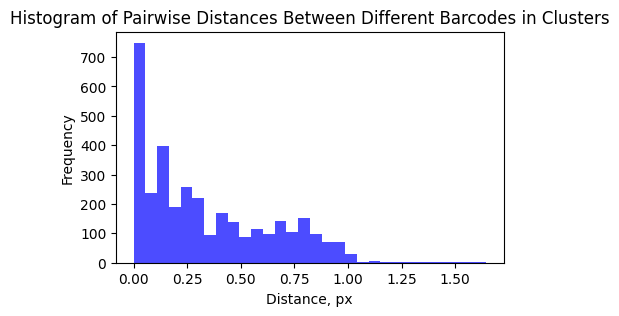

bin array size:100
hist size: (99, 99)
 Amplitude, sigma_x, sigma_y: [6.74119117e+02 8.40829193e-03 8.87918277e-03]
bin array size:100
hist size: (99, 99)
 Amplitude, sigma_x, sigma_y: [8.76961363e+01 1.07582476e-02 5.83828637e-02]
bin array size:100
hist size: (99, 99)
 Amplitude, sigma_x, sigma_y: [8.85051235e+01 1.11730462e-02 5.45163781e-02]


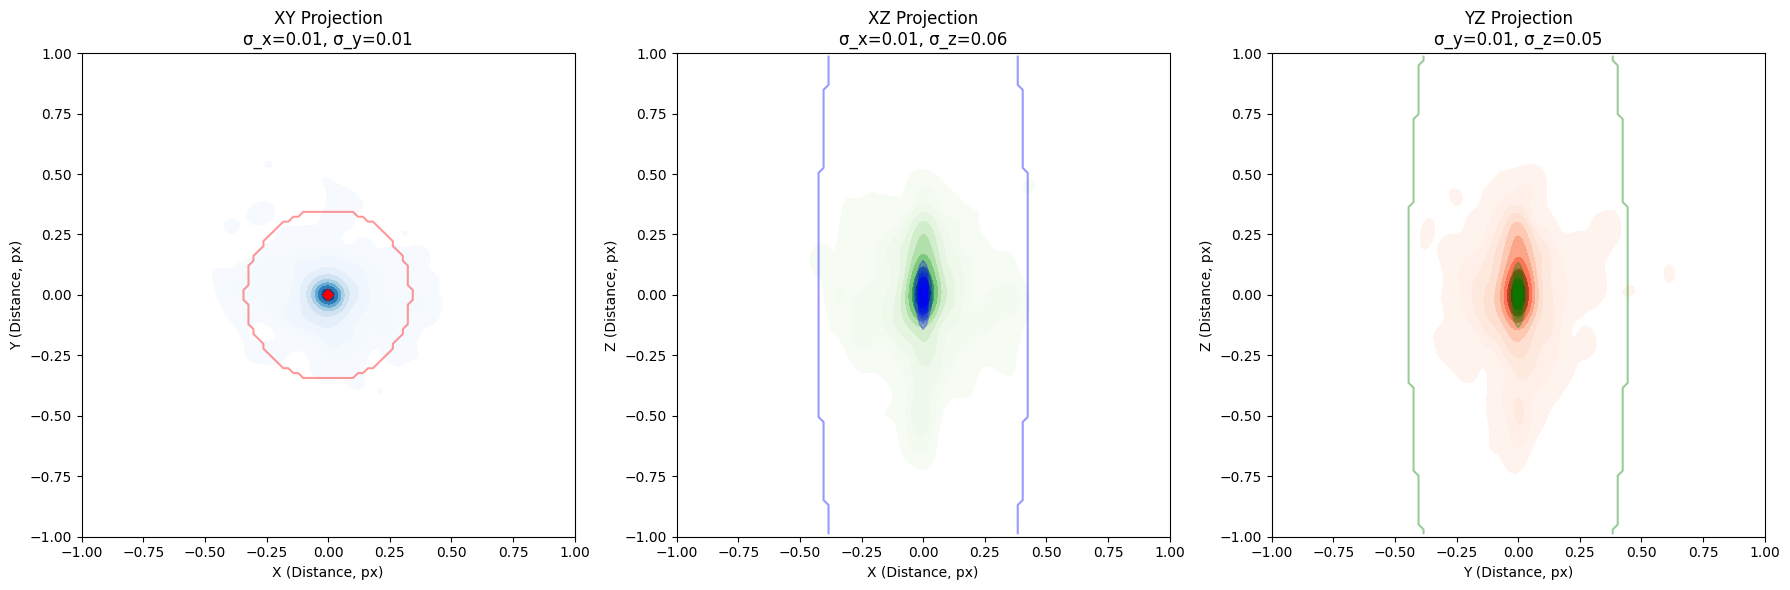

In [90]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from astropy.table import Table
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import socket
from scipy.optimize import curve_fit

# Get the computer name (hostname)
def get_computer_name():
    return socket.gethostname()

# Function to read localizations from a file
def read_localizations(file_path):
    """Read a localizations table from a file."""
    return Table.read(file_path, format='ascii.ecsv')

# Function to compute the center of mass (centroid) for a set of points
def compute_center_of_mass(coordinates):
    """Compute the center of mass of a cluster."""
    return np.mean(coordinates, axis=0)

# Function to translate localizations to the center of mass of each cluster
def translate_to_center_of_mass(coordinates, center_of_mass):
    """Translate the points in a cluster so that the center of mass is at the origin."""
    return coordinates - center_of_mass

# Function to compute pairwise distances within a cluster
def compute_pairwise_distances(coordinates):
    """Compute pairwise distances between points in a cluster."""
    num_points = len(coordinates)
    distances = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distances.append(dist)
    return distances

def twoD_Gaussian(xy, amplitude, sigma_x, sigma_y):
    x, y = xy
    xo = 0. #float(xo)
    yo = 0. #float(yo)    
    theta=0
    offset=0
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


def fit_gaussian_2d(y_data, x_data, bins=100):
    bin_array = [np.linspace(-1, 1, bins),np.linspace(-1, 1, bins)]
    hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=bin_array, density=True)
    hist_size= hist.shape
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    print(f"bin array size:{bin_array[0].shape[0]}\nhist size: {hist_size}")
    # Flatten the meshgrid and histogram for fitting
    x_flat = X.ravel()
    y_flat = Y.ravel()
    hist_flat = hist.ravel()
    
    # Initial guesses for Gaussian parameters
    initial_guess = (np.max(hist),.1, .1)  # amplitude,  sigma_x, sigma_y
    bounds = ( np.array([0, 0, 0]),np.array([np.inf, np.inf, np.inf]))
    
    try:
        # Perform curve fitting with increased maxfev

        params, _ = curve_fit(twoD_Gaussian, (x_flat, y_flat), hist_flat, p0=initial_guess, maxfev=30000, bounds=bounds)

        # Extract sigma values from the fitted parameters
        amp, sigma_x, sigma_y = params
        print(f" Amplitude, sigma_x, sigma_y: {params}")

        data_fitted = twoD_Gaussian((X, Y), *params)
        
        data_fitted = data_fitted.reshape(hist_size[0],hist_size[1])

        return sigma_x, sigma_y, (data_fitted,x_centers,y_centers)
    
    except RuntimeError as e:
        print(f"Error fitting Gaussian: {e}")
        return 0.0, 0.0, None
    

# Modified plot_translated_localizations function
def plot_translated_localizations(translated_coordinates_all_clusters, figure_label=', microns'):
    """Plot the 2D KDE density for XY, XZ, and YZ projections for all clusters."""
    all_xy = []
    all_xz = []
    all_yz = []

    # Collect all the translated coordinates for each projection (XY, XZ, YZ)
    for cluster_coords in translated_coordinates_all_clusters:
        cluster_coords = np.array(cluster_coords)
        #all_xy.append(cluster_coords[:, [0, 1]])  # XY projection
        #all_xz.append(cluster_coords[:, [0, 2]])  # XZ projection
        #all_yz.append(cluster_coords[:, [1, 2]])  # YZ projection
        all_xy.append(cluster_coords[:, [0, 2]])  # XY projection
        all_xz.append(cluster_coords[:, [0, 1]])  # XZ projection
        all_yz.append(cluster_coords[:, [2, 1]])  # YZ projection
    all_xy = np.vstack(all_xy)
    all_xz = np.vstack(all_xz)
    all_yz = np.vstack(all_yz)

    # Fit 2D Gaussians and get sigmas
    sigma_x_xy, sigma_y_xy, (data_fitted_xy,x_centers,y_centers) = fit_gaussian_2d(all_xy[:, 0], all_xy[:, 1])
    sigma_x_xz, sigma_z_xz, (data_fitted_xz,x_centers,y_centers) = fit_gaussian_2d(all_xz[:, 0], all_xz[:, 1])
    sigma_y_yz, sigma_z_yz, (data_fitted_yz,x_centers,y_centers) = fit_gaussian_2d(all_yz[:, 0], all_yz[:, 1])

    # Create a figure with three subplots for XY, XZ, and YZ projections
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # XY projection
    sns.kdeplot(x=all_xy[:, 0], y=all_xy[:, 1], ax=axes[0], fill=True, cmap='Blues', thresh=0.05)
    axes[0].set_title(f'XY Projection\nσ_x={sigma_x_xy:.2f}, σ_y={sigma_y_xy:.2f}')
    axes[0].set_xlabel(f'X ({figure_label})')
    axes[0].set_ylabel(f'Y ({figure_label})')
    axes[0].contour(x_centers, y_centers, data_fitted_xy, 20, colors='r', alpha=.4)

    # XZ projection
    sns.kdeplot(x=all_xz[:, 0], y=all_xz[:, 1], ax=axes[1], fill=True, cmap="Greens", thresh=0.05)
    axes[1].set_title(f'XZ Projection\nσ_x={sigma_x_xz:.2f}, σ_z={sigma_z_xz:.2f}')
    axes[1].set_xlabel(f'X ({figure_label})')
    axes[1].set_ylabel(f'Z ({figure_label})')
    axes[1].contour(x_centers, y_centers, data_fitted_xz, 20, colors='b', alpha=.4)

    # YZ projection
    sns.kdeplot(x=all_yz[:, 0], y=all_yz[:, 1], ax=axes[2], fill=True, cmap="Reds", thresh=0.05)
    axes[2].set_title(f'YZ Projection\nσ_y={sigma_y_yz:.2f}, σ_z={sigma_z_yz:.2f}')
    axes[2].set_xlabel(f'Y ({figure_label})')
    axes[2].set_ylabel(f'Z ({figure_label})')
    axes[2].contour(x_centers, y_centers, data_fitted_yz, 20, colors='g', alpha=.4)

    # Set limits
    for ax in axes:
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

    plt.tight_layout()
    plt.show()


# Main function to process the localizations, run clustering, and plot results
def process_localizations(file_path=None, localizations=None, distance_threshold=1.0):
    """
    Process localizations either from a file or from provided localizations data, 
    run KDTree clustering, and plot the results.
    """

    # If localizations are not provided, read from the file
    if localizations is None:
        if file_path is None:
            raise ValueError("Either file_path or localizations must be provided.")
        localizations = read_localizations(file_path)

    if 'xcentroid' in localizations.keys():
        table_type = 'localizations'
        x_label, y_label, z_label = "xcentroid","ycentroid","zcentroid"
        figure_label = 'Distance, px'
    else:
        table_type = 'trace'
        x_label, y_label, z_label = "x","y","z"
        figure_label = 'Distance, microns'
        
    # Extract coordinates and barcode identities
    coordinates = []
    barcodes = []
    for row in tqdm(localizations, desc="Processing localizations"):
        barcode_number = int(row["Barcode #"])
        x = row[x_label]
        y = row[y_label]
        z = row[z_label]
        coordinates.append([x, y, z])
        barcodes.append(barcode_number)
    
    coordinates = np.array(coordinates)
    barcodes = np.array(barcodes)

    # Build KDTree and find clusters
    tree = KDTree(coordinates)
    clusters = tree.query_ball_tree(tree, distance_threshold)

    # Dictionary to hold pairwise distances for different barcodes within the same cluster
    pairwise_distances = []
    translated_coordinates_all_clusters = []

    # Iterate over the clusters to extract barcodes and calculate distances
    for cluster in tqdm(clusters, desc="Processing clusters"):
        if len(cluster) > 1:  # Only process clusters with more than one point
            cluster_barcodes = barcodes[cluster]
            cluster_coordinates = coordinates[cluster]
            
            # Compute the center of mass of the cluster
            center_of_mass = compute_center_of_mass(cluster_coordinates)
            
            # Translate all points to the center of mass
            translated_coordinates = translate_to_center_of_mass(cluster_coordinates, center_of_mass)
            translated_coordinates_all_clusters.append(translated_coordinates)
            
            # Check if there are different barcodes in the cluster
            if len(np.unique(cluster_barcodes)) > 1:
                distances = compute_pairwise_distances(cluster_coordinates)
                pairwise_distances.extend(distances)

    # Plot histogram of pairwise distances
    plt.figure(figsize=(5, 3))
    plt.hist(pairwise_distances, bins=30, color='blue', alpha=0.7)
    plt.xlabel(figure_label)
    plt.ylabel('Frequency')
    plt.title('Histogram of Pairwise Distances Between Different Barcodes in Clusters')
    plt.show()

    # Visualize the translated localizations with 2D KDE projections
    plot_translated_localizations(translated_coordinates_all_clusters, figure_label = figure_label)


print(f"Computer name: {get_computer_name()}")

if get_computer_name()=="atlantis":
    
    
    # trace table
    folder = '/home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/tracing/data/'
    file_path = folder+"Trace_3D_barcode_KDtree_ROI-1.ecsv"    
    
    # localizations table
    folder = '/home/marcnol/grey/users/marcnol/DEEDs_test/dataset-deformation/shifted_dataset_small/localize_3d/data/'
    file_path = folder+"localizations_3D_barcode_registered_global_xy.dat"
    #file_path = folder+"localizations_3D_barcode_registered_local_xyz.dat"
    
else:
    file_path = "/home/marcnol/data/blobel/tracing/data/Trace_3D_barcode_mask-mask0_ROI-1.ecsv"

process_localizations(file_path)
